## Problem statement

$$ \frac{\partial }{\partial x*} \left(  ( 1 + \epsilon_c \theta )  \frac{\partial \theta }{\partial x*} \right)   - N^2 \theta + N^2 G ( 1 + \epsilon_G \theta ) = 0   $$ 

#### Where: 

- $\theta(x) = \dfrac{T(x) - T_\inf}{T_{b} - T_{\inf}}$


- $N = \sqrt{\dfrac{h P L^2}{ k_0 A }} $


- $G=\dfrac{q_0A}{hP(T_b-T_\inf)}$


- $\epsilon_G=\epsilon(T_b-T_\inf)$


- $\epsilon_C=\beta(T_b-T_\inf)$

#### and the boundary conditions are:

- at $x^* = 0 \rightarrow \theta = 1$

- at $x^* = 1 \rightarrow \dfrac{d\theta}{dx^*} = 0$


**Given a sample which contains 9 values of $x$ and $\theta$ predict $G$** 

## Import libraries 

In [1]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import pandas as pd
import matplotlib.pyplot as plt
# import matplotlib.gridspec as gridspec
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# from mpl_toolkits.mplot3d import Axes3D
# import matplotlib.ticker
# from sklearn.model_selection import train_test_split

import numpy as np
import time
import scipy.io

## Set random seed and select device

In [2]:
#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device == 'cuda': 
    print(torch.cuda.get_device_name())
    
device = 'cpu'
print('Devuce employed:', device)

Devuce employed: cpu


## Load data

In [3]:
## Load dataset
relative_csv_path = "./../src/data/raw/Dataset.csv"
split_ratio = 0.2

# Load a random sample
fields_G = ['G']
fields_T = ['T1', 'T2', 'T3', 'T4' ,'T5', 'T6' ,'T7', 'T8' ,'T9']
fields = fields_T + fields_G
df_T = pd.read_csv(relative_csv_path, skipinitialspace=True, usecols=fields)
random_sample = df_T.sample()
G_real = random_sample[fields_G].to_numpy()
T_real = random_sample[fields_T].to_numpy()
X_real = np.linspace(0,1,T_real.shape[1]).reshape(-1,1)
X_real = X_real.astype(np.float32)
X_bc = X_real[-1].reshape(-1,1)
print(X_real.shape)
print(X_bc.shape)

# compute theta 
T_inf = 27 + 273 #in K
T_b = 127 + 273 #in K
Theta_real = np.multiply(np.add(T_real, [-T_inf]), [1/(T_b - T_inf)]).T
Theta_real = Theta_real.astype(np.float32)
Theta_real = torch.from_numpy(Theta_real)
# prin shapes 
print('Theta real shape is:',Theta_real.shape)
print('X real shape is:',X_real.shape)
print('G_real is:',G_real)

# lower and uper bounds to normalize the input of net U
lb = min(X_real)
ub = max(X_real)
print('lb is %.2f and ub is %.2f' % (lb,ub))
N_u = Theta_real.shape[0]
print("The number real points are", N_u)


(9, 1)
(1, 1)
Theta real shape is: torch.Size([9, 1])
X real shape is: (9, 1)
G_real is: [[0.70303543]]
lb is 0.00 and ub is 1.00
The number real points are 9


### Collocation points ($loss_f$)

In [4]:
N_f = 40 #Total number of collocation points 
f_hat = torch.zeros(N_f,1).to(device)
theta_x_hat = torch.zeros(1,1).to(device)
print("The number of collocation points are", N_f)
offset = .0001
X_train_f = torch.linspace(lb[0] + offset,ub[0] - offset,N_f).reshape(-1,1)



The number of collocation points are 40


## Model hyper parameters

In [15]:
steps = 20000
lr = 500e-4
input_dim = X_real.shape[1]
output_dim = Theta_real.shape[1]
layers = np.array([input_dim,20,20,20,20,20,20,20,20,output_dim]) #number of neurons for each layer
print("The number of layers selected are", layers.size-1)

The number of layers selected are 9


## Deep NN class

In [6]:
#  Deep Neural Network
class DNN(nn.Module):
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()
    
        'Initialize neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers) - 1)])
    
        'Xavier Normal Initialization'
        for i in range(len(layers)-1):
            
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)
            
    'foward pass'
    def forward(self,x):
              
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)
                      
        #preprocessing input 
        x = 2*(x - l_b)/(u_b - l_b)-1 #feature scaling
        
        #convert to float
        a = x.float()
        
        # inpunt and hidden layers forward computation
        for i in range(len(layers)-2):
            
            z = self.linears[i](a)
                        
            a = self.activation(z)

        # output layer forward computation            
        a = self.linears[-1](a)
        
        return a

## PINN class

In [7]:
class PINN():
    def __init__(self, layers):
        
        'Define loss function'
        self.loss_function = nn.MSELoss(reduction ='sum')
        
        'Initialize iterator'
        self.iter = 0
        
        'Initialize our new parameter G, N, ec, eg as tensor (Inverse problem)' 
        self.G = torch.tensor([float(G)], requires_grad=True).float().to(device)  
        self.N = torch.tensor([float(N)], requires_grad=True).float().to(device)  
        self.ec = torch.tensor([float(ec)], requires_grad=True).float().to(device)  
        self.eg = torch.tensor([float(eg)], requires_grad=True).float().to(device)  

                
        'Register parametes to be optimized'
        self.G = nn.Parameter(self.G)
        self.N = nn.Parameter(self.N)
        self.ec= nn.Parameter(self.ec)
        self.eg= nn.Parameter(self.eg)

        'Initialize our DNN'
        self.dnn = DNN(layers).to(device)
        
        'Register our new parameter'
        self.dnn.register_parameter('G', self.G)  
        self.dnn.register_parameter('N', self.N)  
        self.dnn.register_parameter('ec', self.ec)  
        self.dnn.register_parameter('eg', self.eg)  

    def loss_data(self,x,theta_real):
        
#         if torch.is_tensor(x) != True:         
#             x = torch.from_numpy(x)
            
        if torch.is_tensor(theta_real) != True:         
            theta_real = torch.from_numpy(theta_real)
        
        theta_nn = self.dnn(x)
        loss_d = self.loss_function(theta_nn, theta_real)
        
        return loss_d
        
    def loss_PDE(self, x_f):
        
#         if torch.is_tensor(x_f) != True:         
#             x_f = torch.from_numpy(x_f)     
                   
        # extract the PDE parameters
        G = self.G
        N = self.N
        ec = self.ec
        eg = self.eg

        # clone the input data and add AD
        x = x_f.clone()
        x.requires_grad = True
        
        # predict theta
        theta = self.dnn(x)
        
        # compute derivatives 
        theta_x = autograd.grad(theta, x, torch.ones([x_f.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        
        # copmute term to be derived
        aux = (1 + ec * theta) * theta_x

        aux_x = autograd.grad(aux, x, torch.ones(x_f.shape).to(device), create_graph=True)[0]
#         print(G)
        
        # PDE f  = 0
        f = aux_x - N**2*theta + N**2*G*(1 + eg*theta)   

        # f_hat is just an auxiliar term to copmute the loss (is zero)
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f
    
    def loss_BC(self,x_bc):
        
        if torch.is_tensor(x_bc) != True:         
            x_bc = torch.from_numpy(x_bc)

        # clone the input data and add AD
        x = x_bc.clone()
        x.requires_grad = True
        
        # predict theta
        theta = self.dnn(x)
        
        # compute derivatives 
        theta_x = autograd.grad(theta, x, torch.ones([x_bc.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        
        loss_bc = self.loss_function(theta_x, theta_x_hat)
        
        return loss_bc
    
    
    def loss(self,x_real,theta_real,x_f,x_bc):

        loss_d  = self.loss_data(x_real, theta_real)
        loss_f  = self.loss_PDE(x_f)
        loss_bc = self.loss_BC(x_bc)
        
        loss_val = loss_d + loss_f + loss_bc
        
        return loss_val
     
#     'callable for optimizer'                                       
#     def closure(self):
        
#         optimizer.zero_grad()
        
#         loss = self.loss(X_real, Theta_real, X_train_f)
        
#         loss.backward()
                
#         self.iter += 1
        
#         print(
#             'Loss error(Train): %.5f , G_real = [%.5f], G_PINN = [%.5f]' %
#             (
#                 loss.cpu().detach().numpy(),
#                 G_real,
#                 self.G.item(),
#             )
#         )
                

#         return loss        
    
    'foward pass'
    def forward(self,x):
        return self.dnn(x)
    
    'test neural network'
    def test(self):
                
        theta_pred = self.dnn(X_real)
        
        error_vec = torch.linalg.norm((Theta_real - theta_pred),2)/torch.linalg.norm(Theta_real,2)        # Relative L2 Norm of the error (Vector)
        
        theta_pred = theta_pred.cpu().detach().numpy()
                        
        return error_vec, theta_pred

In [8]:
G = .5
N = 2
ec = .4
eg = .2
print("Te real G = [",G_real,"]. Our initial guess will be G_PINN= [",G,"]")
print("Our initial of the other params are: \n N  = [",N,"]\n eg = [",eg,"] \n ec = [",ec,"]")

Te real G = [ [[0.70303543]] ]. Our initial guess will be G_PINN= [ 0.5 ]
Our initial of the other params are: 
 N  = [ 2 ]
 eg = [ 0.2 ] 
 ec = [ 0.4 ]


## Train the model


In [16]:
'Neural Network Summary'
pinn = PINN(layers)

'Neural Network Parameters'
params = list(pinn.dnn.parameters())

'L-BFGS Optimizer'
optimizer = torch.optim.Adam(params, lr, 
                             amsgrad = True)


'Store losses and predicted G values'
loss_theta = np.zeros((steps,))
loss_f = np.zeros((steps,))
loss_bc = np.zeros((steps,))
loss_hist = np.zeros((steps,))
G_hist = np.zeros((steps,))
N_hist = np.zeros((steps,))
ec_hist = np.zeros((steps,))
eg_hist = np.zeros((steps,))


'Train the model'
for epoch in range(steps):
    if epoch%20 == 0:
        print('Voy en la vuelta número {} y G = {}'.format(epoch,G_hist[epoch-1]))
    # compute net U prediction
    theta_nn = pinn.dnn(X_real)
    # compute losses
    loss_theta[epoch] = pinn.loss_data(X_real, Theta_real).to('cpu').detach().numpy()
    loss_f[epoch]     = pinn.loss_PDE(X_train_f).to('cpu').detach().numpy()
    loss_bc[epoch]    = pinn.loss_BC(X_bc).to('cpu').detach().numpy()
    loss = pinn.loss(X_real, Theta_real, X_train_f,X_bc)
    loss_hist[epoch] = loss.to('cpu').detach().numpy()
    # store parameters 
    G_hist[epoch], N_hist[epoch], ec_hist[epoch], eg_hist[epoch]  = pinn.G, pinn.N, pinn.ec, pinn.eg
    
    # update parameters
    optimizer.zero_grad()       # Zero Out the gradient
    loss.backward()    
    optimizer.step()
    
    test_error, _ = pinn.test()


Voy en la vuelta número 0 y G = 0.0
Voy en la vuelta número 20 y G = 0.6021860837936401
Voy en la vuelta número 40 y G = 0.7858505845069885
Voy en la vuelta número 60 y G = 0.760692298412323
Voy en la vuelta número 80 y G = 0.7685014605522156
Voy en la vuelta número 100 y G = 0.7550222873687744
Voy en la vuelta número 120 y G = 0.7469331622123718
Voy en la vuelta número 140 y G = 0.736558735370636
Voy en la vuelta número 160 y G = 0.7271488904953003
Voy en la vuelta número 180 y G = 0.7180365324020386
Voy en la vuelta número 200 y G = 0.7094715237617493
Voy en la vuelta número 220 y G = 0.7015265822410583
Voy en la vuelta número 240 y G = 0.694255530834198
Voy en la vuelta número 260 y G = 0.6876842379570007
Voy en la vuelta número 280 y G = 0.6818159222602844
Voy en la vuelta número 300 y G = 0.676633358001709
Voy en la vuelta número 320 y G = 0.6721043586730957
Voy en la vuelta número 340 y G = 0.6681853532791138
Voy en la vuelta número 360 y G = 0.6648250818252563
Voy en la vuelta n

Voy en la vuelta número 3100 y G = 0.6499538421630859
Voy en la vuelta número 3120 y G = 0.6499550342559814
Voy en la vuelta número 3140 y G = 0.649956226348877
Voy en la vuelta número 3160 y G = 0.6499574184417725
Voy en la vuelta número 3180 y G = 0.649958610534668
Voy en la vuelta número 3200 y G = 0.6499598026275635
Voy en la vuelta número 3220 y G = 0.649960994720459
Voy en la vuelta número 3240 y G = 0.6499621868133545
Voy en la vuelta número 3260 y G = 0.64996337890625
Voy en la vuelta número 3280 y G = 0.6499645709991455
Voy en la vuelta número 3300 y G = 0.649965763092041
Voy en la vuelta número 3320 y G = 0.6499668955802917
Voy en la vuelta número 3340 y G = 0.6499678492546082
Voy en la vuelta número 3360 y G = 0.6499688029289246
Voy en la vuelta número 3380 y G = 0.649969756603241
Voy en la vuelta número 3400 y G = 0.6499704718589783
Voy en la vuelta número 3420 y G = 0.6499713659286499
Voy en la vuelta número 3440 y G = 0.6499723196029663
Voy en la vuelta número 3460 y G = 

Voy en la vuelta número 6180 y G = 0.6499901413917542
Voy en la vuelta número 6200 y G = 0.6499902606010437
Voy en la vuelta número 6220 y G = 0.6499903798103333
Voy en la vuelta número 6240 y G = 0.6499903798103333
Voy en la vuelta número 6260 y G = 0.649990439414978
Voy en la vuelta número 6280 y G = 0.6499904990196228
Voy en la vuelta número 6300 y G = 0.6499904990196228
Voy en la vuelta número 6320 y G = 0.6499904990196228
Voy en la vuelta número 6340 y G = 0.6499904990196228
Voy en la vuelta número 6360 y G = 0.6499906778335571
Voy en la vuelta número 6380 y G = 0.6499907970428467
Voy en la vuelta número 6400 y G = 0.649990975856781
Voy en la vuelta número 6420 y G = 0.6499911546707153
Voy en la vuelta número 6440 y G = 0.6499912142753601
Voy en la vuelta número 6460 y G = 0.6499912738800049
Voy en la vuelta número 6480 y G = 0.6499912738800049
Voy en la vuelta número 6500 y G = 0.6499913930892944
Voy en la vuelta número 6520 y G = 0.6499915719032288
Voy en la vuelta número 6540 y

Voy en la vuelta número 9240 y G = 0.6500112414360046
Voy en la vuelta número 9260 y G = 0.6500113606452942
Voy en la vuelta número 9280 y G = 0.6500116586685181
Voy en la vuelta número 9300 y G = 0.6500120759010315
Voy en la vuelta número 9320 y G = 0.6500123739242554
Voy en la vuelta número 9340 y G = 0.6500128507614136
Voy en la vuelta número 9360 y G = 0.6500131487846375
Voy en la vuelta número 9380 y G = 0.6500132083892822
Voy en la vuelta número 9400 y G = 0.6500133275985718
Voy en la vuelta número 9420 y G = 0.6500135064125061
Voy en la vuelta número 9440 y G = 0.6500137448310852
Voy en la vuelta número 9460 y G = 0.6500139236450195
Voy en la vuelta número 9480 y G = 0.6500141024589539
Voy en la vuelta número 9500 y G = 0.6500144004821777
Voy en la vuelta número 9520 y G = 0.6500147581100464
Voy en la vuelta número 9540 y G = 0.650015115737915
Voy en la vuelta número 9560 y G = 0.6500155329704285
Voy en la vuelta número 9580 y G = 0.6500157713890076
Voy en la vuelta número 9600 

Voy en la vuelta número 12260 y G = 0.6500901579856873
Voy en la vuelta número 12280 y G = 0.6500908732414246
Voy en la vuelta número 12300 y G = 0.6500917077064514
Voy en la vuelta número 12320 y G = 0.6500925421714783
Voy en la vuelta número 12340 y G = 0.6500933170318604
Voy en la vuelta número 12360 y G = 0.6500941514968872
Voy en la vuelta número 12380 y G = 0.6500949859619141
Voy en la vuelta número 12400 y G = 0.6500958204269409
Voy en la vuelta número 12420 y G = 0.6500966548919678
Voy en la vuelta número 12440 y G = 0.6500974297523499
Voy en la vuelta número 12460 y G = 0.6500982642173767
Voy en la vuelta número 12480 y G = 0.6500990390777588
Voy en la vuelta número 12500 y G = 0.6500998139381409
Voy en la vuelta número 12520 y G = 0.6501007676124573
Voy en la vuelta número 12540 y G = 0.6501016020774841
Voy en la vuelta número 12560 y G = 0.6501023173332214
Voy en la vuelta número 12580 y G = 0.6501032114028931
Voy en la vuelta número 12600 y G = 0.6501039266586304
Voy en la 

Voy en la vuelta número 15260 y G = 0.6502352952957153
Voy en la vuelta número 15280 y G = 0.6502364277839661
Voy en la vuelta número 15300 y G = 0.6502375602722168
Voy en la vuelta número 15320 y G = 0.6502386927604675
Voy en la vuelta número 15340 y G = 0.650239884853363
Voy en la vuelta número 15360 y G = 0.6502410173416138
Voy en la vuelta número 15380 y G = 0.6502420902252197
Voy en la vuelta número 15400 y G = 0.6502431631088257
Voy en la vuelta número 15420 y G = 0.6502442955970764
Voy en la vuelta número 15440 y G = 0.6502454280853271
Voy en la vuelta número 15460 y G = 0.6502466201782227
Voy en la vuelta número 15480 y G = 0.6502477526664734
Voy en la vuelta número 15500 y G = 0.6502488851547241
Voy en la vuelta número 15520 y G = 0.6502500176429749
Voy en la vuelta número 15540 y G = 0.6502510905265808
Voy en la vuelta número 15560 y G = 0.6502522230148315
Voy en la vuelta número 15580 y G = 0.650253415107727
Voy en la vuelta número 15600 y G = 0.6502546072006226
Voy en la vu

Voy en la vuelta número 18260 y G = 0.6504258513450623
Voy en la vuelta número 18280 y G = 0.6504272818565369
Voy en la vuelta número 18300 y G = 0.6504286527633667
Voy en la vuelta número 18320 y G = 0.6504300236701965
Voy en la vuelta número 18340 y G = 0.6504314541816711
Voy en la vuelta número 18360 y G = 0.6504328846931458
Voy en la vuelta número 18380 y G = 0.6504343152046204
Voy en la vuelta número 18400 y G = 0.650435745716095
Voy en la vuelta número 18420 y G = 0.6504371166229248
Voy en la vuelta número 18440 y G = 0.6504384279251099
Voy en la vuelta número 18460 y G = 0.6504397988319397
Voy en la vuelta número 18480 y G = 0.6504412889480591
Voy en la vuelta número 18500 y G = 0.6504426002502441
Voy en la vuelta número 18520 y G = 0.6504440307617188
Voy en la vuelta número 18540 y G = 0.6504454612731934
Voy en la vuelta número 18560 y G = 0.6504469513893127
Voy en la vuelta número 18580 y G = 0.6504483819007874
Voy en la vuelta número 18600 y G = 0.6504497528076172
Voy en la v

# Losses vs num epochs 

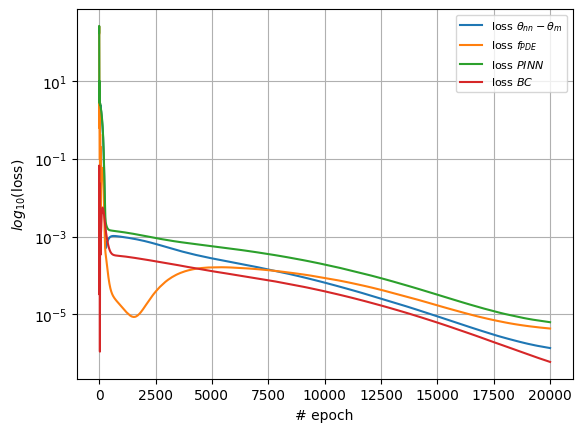

In [10]:
plt.cla()
plt.plot(range(steps),loss_theta, label = r'loss $\theta_{nn} - \theta_{m}$')
plt.plot(range(steps),loss_f, label = r'loss $f_{PDE}$')
plt.plot(range(steps),loss_hist, label = r'loss $PINN$')
plt.plot(range(steps),loss_bc, label = r'loss $BC$')
# plt.plot(range(steps),loss_theta + loss_f)

plt.legend(loc='upper right', prop={'size': 8})
plt.xlabel('# epoch')
plt.yscale('log')
plt.ylabel(r'$log_{10}$(loss)')
plt.grid(True, which="both", ls="-")
# plt.savefig('part1_outputs/figures/loss_vs_nepoch_without_norm.png')
plt.show()

## PDE Parameters ($G$, $N$, $\epsilon_c$, $\epsilon_g$) value vs num epochs

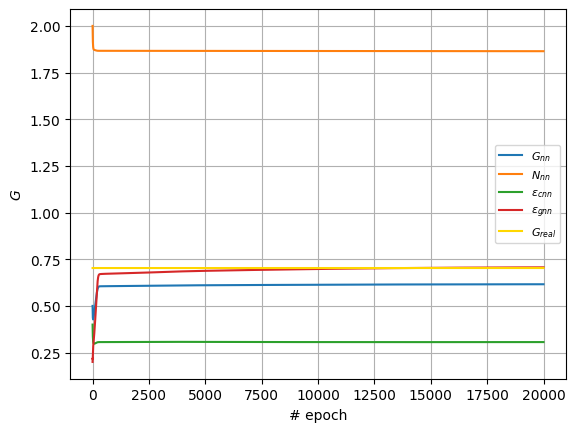

In [11]:
plt.cla()
plt.plot(range(steps), G_hist, label = r'$G_{nn}$')
plt.plot(range(steps), N_hist, label = r'$N_{nn}$')
plt.plot(range(steps), ec_hist, label = r'$\epsilon_{cnn}$')
plt.plot(range(steps), eg_hist, label = r'$\epsilon_{gnn}$')

plt.plot(range(steps), G_real*np.ones((steps,1)), label = r'$G_{real}$', color = 'gold')
plt.legend(loc='best', prop={'size': 8})
plt.xlabel('# epoch')
plt.ylabel(r'$G$')
plt.grid(True, which="both", ls="-")


##  Plot $\theta(x)$ solution

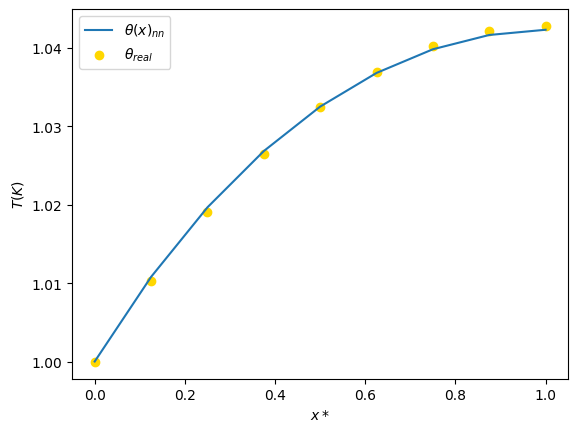

In [12]:
# compute theta values
x_u = X_real
theta_real = Theta_real.to('cpu').detach().numpy()
x_f = X_train_f.to('cpu').detach().numpy()
theta_nn = pinn.forward(X_real).to('cpu').detach().numpy()

# plt.cla()
plt.plot(x_u, theta_nn, label = r'$\theta(x)_{nn}$')
plt.scatter(x_u, theta_real, label = r'$\theta_{real}$', color = 'gold')

plt.xlabel('$x*$')
plt.ylabel('$T(K)$')
plt.legend(loc='upper left', prop={'size': 10})


In [13]:
pinn.loss_BC(X_bc)

tensor(6.0190e-07, grad_fn=<MseLossBackward0>)

In [14]:
pinn.G

Parameter containing:
tensor([0.6161], requires_grad=True)